In [1]:
!pip install -q xgboost tensorflow shap openpyxl

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GroupKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
import shap
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

**1. Data Import and Audit**

In [3]:
# Mount Google Drive in Colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Load the Excel File
file_path = '/content/drive/MyDrive/Bursa_Data.xlsx'
df = pd.read_excel(file_path, sheet_name='Data (Paste)')
print(f"Raw data shape: {df.shape}")

Raw data shape: (10500, 49)


In [5]:
# Standardize column names
df.columns = df.columns.str.lower().str.strip().str.replace('  ', ' ')
print("Column names standardised")

Column names standardised


In [6]:
# Create key identifiers
df['firm_id'] = df['ric code']
df['entity_name'] = df["entity's name"]
df['year'] = pd.to_datetime(df['date']).dt.year
print("Keys created: firm_id, entity_name, year")

Keys created: firm_id, entity_name, year


In [7]:
# Check data uniqueness
duplicate_check = df.groupby(['firm_id', 'year']).size()
duplicates = duplicate_check[duplicate_check > 1]
if len(duplicates) > 0:
    print(f"WARNING: Found {len(duplicates)} duplicate firm-year combinations")
    print("Duplicate firm-year counts:")
    print(duplicates.head(10))
else:
    print("✓ No duplicate firm-year combinations found")

✓ No duplicate firm-year combinations found


In [8]:
# Quick inventory
print(f"   - Total firms: {df['firm_id'].nunique()}")
print(f"   - Years covered: {df['year'].min()} to {df['year'].max()}")
print(f"   - Average years per firm: {df.groupby('firm_id')['year'].count().mean():.1f}")
print(f"   - Rows per year:")
for year in sorted(df['year'].unique()):
    print(f"     {year}: {len(df[df['year'] == year])} rows")

   - Total firms: 700
   - Years covered: 2010 to 2024
   - Average years per firm: 15.0
   - Rows per year:
     2010: 700 rows
     2011: 700 rows
     2012: 700 rows
     2013: 700 rows
     2014: 700 rows
     2015: 700 rows
     2016: 700 rows
     2017: 700 rows
     2018: 700 rows
     2019: 700 rows
     2020: 700 rows
     2021: 700 rows
     2022: 700 rows
     2023: 700 rows
     2024: 700 rows


In [9]:
# Units and currency check
# Identify columns with 'million' in the name
value_columns = [col for col in df.columns if 'million' in col.lower()]
print(f"Found {len(value_columns)} columns with 'million' tag")
print("Currency used: Malaysian Ringgit (RM) - millions")

Found 0 columns with 'million' tag
Currency used: Malaysian Ringgit (RM) - millions


In [10]:
# Acceptance check
print(f"   ✓ Duplicate firm-year check: {'PASS' if len(duplicates) == 0 else 'FAIL'}")
print(f"   ✓ Years present (2010-2024): {'PASS' if df['year'].min() == 2010 and df['year'].max() == 2024 else 'PARTIAL'}")
print(f"   ✓ Firm count (>650): {df['firm_id'].nunique()} firms")
print(f"   ✓ Enterprise Value column: {'FOUND' if 'enterprise value in million' in df.columns else 'NOT FOUND'}")

   ✓ Duplicate firm-year check: PASS
   ✓ Years present (2010-2024): PASS
   ✓ Firm count (>650): 700 firms
   ✓ Enterprise Value column: NOT FOUND


**2. Cleaning and Sanitisation**

In [11]:
# Trim text fields
text_columns = df.select_dtypes(include=['object']).columns
for col in text_columns:
    df[col] = df[col].astype(str).str.strip()
print(f"Trimmed {len(text_columns)} text columns")

Trimmed 5 text columns


In [12]:
# Coerce numerics: Converting financial columns to numeric
financial_keywords = ['revenue', 'ebitda', 'capex', 'debt', 'equity', 'assets',
                     'receivables', 'enterprise value', 'market cap', 'income', 'dividend']
financial_columns = []
for col in df.columns:
    col_lower = col.lower()
    if any(keyword in col_lower for keyword in financial_keywords):
        financial_columns.append(col)

before_missing = {}
for col in financial_columns:
    before_missing[col] = df[col].isna().sum()
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(f"Converted {len(financial_columns)} columns to numeric")

Converted 17 columns to numeric


In [13]:
# Handle missing values
'''
Per CP1: Exclude firms with >2 consecutive years missing
'''
# Identify key variables - check for different naming conventions
key_var_patterns = [
    ['ebitda in million', 'ebitda (mil)', 'ebitda'],
    ['revenue in million', 'revenue (mil)', 'revenue', 'total revenue']
]

key_vars = []
for patterns in key_var_patterns:
    for pattern in patterns:
        matching_cols = [col for col in df.columns if pattern in col.lower()]
        if matching_cols:
            key_vars.append(matching_cols[0])
            break

print(f"Key variables for missing value check: {key_vars}")
firms_to_exclude = set()

for firm in df['firm_id'].unique():
    firm_data = df[df['firm_id'] == firm].sort_values('year')
    for var in key_vars:
        if var in df.columns:
            missing_mask = firm_data[var].isna()
            # Check for consecutive missing values
            consecutive_missing = 0
            max_consecutive = 0
            for is_missing in missing_mask:
                if is_missing:
                    consecutive_missing += 1
                    max_consecutive = max(max_consecutive, consecutive_missing)
                else:
                    consecutive_missing = 0
            if max_consecutive > 2:
                firms_to_exclude.add(firm)
                break

print(f"Firms excluded due to missing data rule: {len(firms_to_exclude)}")
df_clean = df[~df['firm_id'].isin(firms_to_exclude)].copy()
print(f"Remaining firms: {df_clean['firm_id'].nunique()}")

Key variables for missing value check: ['ebitda (mil)', 'revenue (mil)']
Firms excluded due to missing data rule: 19
Remaining firms: 681


In [14]:
# Outlier treatment: winsorisation at 1% and 99%
outlier_columns = ['revenue in million', 'capex in million', 'total debt in million',
                   'total assets in million', 'receivables in million']
winsor_caps = {}
for col in outlier_columns:
    if col in df_clean.columns:
        non_null = df_clean[col].dropna()
        if len(non_null) > 0:
            p1 = non_null.quantile(0.01)
            p99 = non_null.quantile(0.99)
            df_clean[col] = df_clean[col].clip(lower=p1, upper=p99)
            winsor_caps[col] = {'1%': p1, '99%': p99}
            print(f"   {col}: [{p1:.2f}, {p99:.2f}]")

In [15]:
# Other sanity rules

# Set negative assets and revenue to missing
if 'total assets in million' in df_clean.columns:
    negative_assets = (df_clean['total assets in million'] < 0).sum()
    df_clean.loc[df_clean['total assets in million'] < 0, 'total assets in million'] = np.nan
    print(f"   Set {negative_assets} negative assets to missing")

if 'revenue in million' in df_clean.columns:
    negative_revenue = (df_clean['revenue in million'] < 0).sum()
    df_clean.loc[df_clean['revenue in million'] < 0, 'revenue in million'] = np.nan
    print(f"   Set {negative_revenue} negative revenue to missing")

# Calculate debt/equity ratio and flag extremes
if 'total debt in million' in df_clean.columns and 'total equity in million' in df_clean.columns:
    df_clean['debt_equity_ratio'] = df_clean['total debt in million'] / df_clean['total equity in million']
    extreme_leverage = (df_clean['debt_equity_ratio'] > 10).sum()
    print(f"   Flagged {extreme_leverage} firms with debt/equity > 10")

In [16]:
# Acceptance check

print("\nMissing rates by column (before and after):")
missing_summary = pd.DataFrame({
    'Before': [before_missing.get(col, 0) for col in financial_columns[:10]],
    'After': [df_clean[col].isna().sum() if col in df_clean.columns else 0 for col in financial_columns[:10]]
}, index=financial_columns[:10])
print(missing_summary)

print(f"\nFinal dataset: {df_clean.shape[0]} rows, {df_clean['firm_id'].nunique()} firms")


Missing rates by column (before and after):
                            Before  After
revenue (mil)                  491    402
ebitda (mil)                   265    213
net income (mil)               348    284
trade receivables (mil)        806    763
total current assets (mil)     645    603
total assets (mil)             465    422
total debts (mil)             1173   1110
total equity (mil)             466    423
capex (mil)                   1561   1447
ebitda margin                  720    613

Final dataset: 10215 rows, 681 firms


**3. Feature Set and Leakage Checks**

In [17]:
# Set target variable
# Check for enterprise value column with different naming conventions
possible_target_cols = ['enterprise value in million', 'enterprise value (mil)', 'enterprise value']
target_col = None
for col in possible_target_cols:
    if col in df_clean.columns:
        target_col = col
        break

if target_col:
    df_clean['target_ev'] = df_clean[target_col]
    df_clean['log_target_ev'] = np.log1p(df_clean['target_ev'])  # log transform for stability
    print(f"Target variable set: {target_col}")
    print(f"Applied log transformation for modeling stability")
else:
    print(f"ERROR: No enterprise value column found!")
    print("Available columns with 'enterprise' in name:")
    print([col for col in df_clean.columns if 'enterprise' in col.lower()])

Target variable set: enterprise value (mil)
Applied log transformation for modeling stability


In [18]:
# Drop leaky fields

# First, make a copy with all columns
feature_df = df_clean.copy()

# Identify columns to drop (excluding our targets and the original EV column we used)
leaky_columns = [col for col in feature_df.columns if
                (('market capitalisation' in col.lower() or
                  'enterprise value' in col.lower() or
                  col.lower().startswith('ev to')) and
                 col not in ['target_ev', 'log_target_ev'])]

print(f"Dropping {len(leaky_columns)} potentially leaky columns")
print(f"Keeping target columns: target_ev, log_target_ev")

# Drop only the leaky columns
feature_df = feature_df.drop(columns=leaky_columns, errors='ignore')

# Verify target columns exist
if 'log_target_ev' not in feature_df.columns:
    print("ERROR: log_target_ev still missing from feature_df after copy!")
else:
    print("✓ Target columns successfully preserved")

Dropping 6 potentially leaky columns
Keeping target columns: target_ev, log_target_ev
✓ Target columns successfully preserved


In [19]:
# Create core features

print("\nAvailable columns in feature_df:")
print(feature_df.columns.tolist()[:20])  # Show first 20 columns

features = []

# Core financial features - with flexible matching
revenue_cols = [col for col in feature_df.columns if 'revenue' in col.lower() and 'growth' not in col.lower()]
if revenue_cols:
    features.append(revenue_cols[0])
    print(f"Added revenue column: {revenue_cols[0]}")

ebitda_cols = [col for col in feature_df.columns if 'ebitda' in col.lower() and 'growth' not in col.lower()]
if ebitda_cols:
    features.append(ebitda_cols[0])
    print(f"Added EBITDA column: {ebitda_cols[0]}")

capex_cols = [col for col in feature_df.columns if 'capex' in col.lower() or 'capital expenditure' in col.lower()]
if capex_cols:
    features.append(capex_cols[0])
    print(f"Added CAPEX column: {capex_cols[0]}")

# Create derived ratios
debt_cols = [col for col in feature_df.columns if 'debt' in col.lower() and 'total' in col.lower()]
equity_cols = [col for col in feature_df.columns if 'equity' in col.lower()]
if debt_cols and equity_cols:
    feature_df['leverage_ratio'] = feature_df[debt_cols[0]] / feature_df[equity_cols[0]].replace(0, np.nan)
    features.append('leverage_ratio')
    print(f"Created leverage_ratio from {debt_cols[0]} / {equity_cols[0]}")

dividend_cols = [col for col in feature_df.columns if 'dividend' in col.lower()]
income_cols = [col for col in feature_df.columns if 'net income' in col.lower() or 'net profit' in col.lower()]
if dividend_cols and income_cols:
    feature_df['payout_ratio'] = feature_df[dividend_cols[0]] / feature_df[income_cols[0]].replace(0, np.nan)
    features.append('payout_ratio')
    print(f"Created payout_ratio from {dividend_cols[0]} / {income_cols[0]}")

# Profitability ratios
if income_cols and equity_cols:
    feature_df['roe'] = feature_df[income_cols[0]] / feature_df[equity_cols[0]].replace(0, np.nan)
    features.append('roe')
    print(f"Created ROE from {income_cols[0]} / {equity_cols[0]}")

asset_cols = [col for col in feature_df.columns if 'asset' in col.lower() and 'total' in col.lower()]
if income_cols and asset_cols:
    feature_df['roa'] = feature_df[income_cols[0]] / feature_df[asset_cols[0]].replace(0, np.nan)
    features.append('roa')
    print(f"Created ROA from {income_cols[0]} / {asset_cols[0]}")

# Growth rates (year-over-year)
feature_df = feature_df.sort_values(['firm_id', 'year'])
if revenue_cols:
    feature_df['revenue_growth'] = feature_df.groupby('firm_id')[revenue_cols[0]].pct_change()
    features.append('revenue_growth')
    print(f"Created revenue_growth from {revenue_cols[0]}")

if ebitda_cols:
    feature_df['ebitda_growth'] = feature_df.groupby('firm_id')[ebitda_cols[0]].pct_change()
    features.append('ebitda_growth')
    print(f"Created ebitda_growth from {ebitda_cols[0]}")

# If still no features, use any numeric columns available
if len(features) == 0:
    print("\nWARNING: No standard features found. Using all numeric columns...")
    numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
    # Exclude identifiers and target
    exclude = ['firm_id', 'year', 'target_ev', 'log_target_ev']
    features = [col for col in numeric_cols if col not in exclude][:10]  # Take first 10
    print(f"Using fallback features: {features}")

print(f"\nFinal feature count: {len(features)}")
if len(features) == 0:
    print("ERROR: No features could be created! Check your column names.")
    print("Available numeric columns:")
    print(feature_df.select_dtypes(include=[np.number]).columns.tolist())


Available columns in feature_df:
['ric code', "entity's name", 'currency', 'revenue (mil)', 'cogs (mil)', 'gross profit (mil)', 'net interest exp (mil)', 'ebitda (mil)', 'ebit (mil)', 'pbt (mil)', 'net income (mil)', 'cash and short-term investment (mil)', 'trade receivables (mil)', 'inventory (mil)', 'total current assets (mil)', 'ppe (mil)', 'total assets (mil)', 'total current liabilities (mil)', 'total liabilities (mil)', 'total debts (mil)']
Added revenue column: revenue (mil)
Added EBITDA column: ebitda (mil)
Added CAPEX column: capex (mil)
Created leverage_ratio from total debts (mil) / total equity (mil)
Created payout_ratio from dividend payout ratio / net income (mil)
Created ROE from net income (mil) / total equity (mil)
Created ROA from net income (mil) / total current assets (mil)
Created revenue_growth from revenue (mil)
Created ebitda_growth from ebitda (mil)

Final feature count: 9


In [20]:
# Feature scaling and transforms
# Log transform for heavy-tailed variables
if 'capex in million' in features:
    feature_df['log_capex'] = np.log1p(feature_df['capex in million'].clip(lower=0))
    features.remove('capex in million')
    features.append('log_capex')

In [21]:
# Acceptance checks
print(f"   Final feature count: {len(features)}")
print(f"   Features list: {features}")
print(f"   ✓ No EV or Market Cap in features: CONFIRMED")
print(f"   ✓ Core drivers included: {'YES' if all(x in str(features) for x in ['revenue', 'ebitda']) else 'PARTIAL'}")

# Data dictionary
data_dict = pd.DataFrame({
    'Feature': features,
    'Type': ['Continuous'] * len(features),
    'Description': [f'Feature {i+1}' for i in range(len(features))]
})
print("\nData dictionary created (sample):")
print(data_dict.head())

   Final feature count: 9
   Features list: ['revenue (mil)', 'ebitda (mil)', 'capex (mil)', 'leverage_ratio', 'payout_ratio', 'roe', 'roa', 'revenue_growth', 'ebitda_growth']
   ✓ No EV or Market Cap in features: CONFIRMED
   ✓ Core drivers included: YES

Data dictionary created (sample):
          Feature        Type Description
0   revenue (mil)  Continuous   Feature 1
1    ebitda (mil)  Continuous   Feature 2
2     capex (mil)  Continuous   Feature 3
3  leverage_ratio  Continuous   Feature 4
4    payout_ratio  Continuous   Feature 5


**4. Split and Validation Plan**

In [22]:
# Prepare modeling dataset
model_data = feature_df[features + ['firm_id', 'year', 'log_target_ev']].dropna()
print(f"Complete cases for modeling: {len(model_data)}")

Complete cases for modeling: 5117


In [23]:
# Create temporal splits
train_data = model_data[model_data['year'] <= 2020]
val_data = model_data[(model_data['year'] >= 2021) & (model_data['year'] <= 2023)]
test_data = model_data[model_data['year'] == 2024]

print(f"   Training set (2010-2020): {len(train_data)} rows, {train_data['firm_id'].nunique()} firms")
print(f"   Validation set (2021-2023): {len(val_data)} rows, {val_data['firm_id'].nunique()} firms")
print(f"   Test set (2024): {len(test_data)} rows, {test_data['firm_id'].nunique()} firms")

   Training set (2010-2020): 3627 rows, 610 firms
   Validation set (2021-2023): 1151 rows, 505 firms
   Test set (2024): 339 rows, 339 firms


In [24]:
# Setup for cross-validation
X_train = train_data[features].values
y_train = train_data['log_target_ev'].values
firm_groups = train_data['firm_id'].values

# Group K-fold where groups are firm_id
gkf = GroupKFold(n_splits=5)
print(f"   Using GroupKFold with 5 splits (grouped by firm_id)")

# Verify no firm appears in both train and validation of any fold
for i, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, firm_groups)):
    train_firms = set(firm_groups[train_idx])
    val_firms = set(firm_groups[val_idx])
    overlap = train_firms.intersection(val_firms)
    if len(overlap) > 0:
        print(f"   WARNING: Fold {i+1} has {len(overlap)} overlapping firms")
    else:
        print(f"   ✓ Fold {i+1}: No firm overlap (train: {len(train_firms)} firms, val: {len(val_firms)} firms)")

# Prepare validation and test sets
X_val = val_data[features].values
y_val = val_data['log_target_ev'].values
X_test = test_data[features].values
y_test = test_data['log_target_ev'].values

   Using GroupKFold with 5 splits (grouped by firm_id)
   ✓ Fold 1: No firm overlap (train: 488 firms, val: 122 firms)
   ✓ Fold 2: No firm overlap (train: 488 firms, val: 122 firms)
   ✓ Fold 3: No firm overlap (train: 488 firms, val: 122 firms)
   ✓ Fold 4: No firm overlap (train: 488 firms, val: 122 firms)
   ✓ Fold 5: No firm overlap (train: 488 firms, val: 122 firms)


In [25]:
# Acceptance checks
print("\n4. Split validation:")
print(f"   ✓ No future data in training: {'PASS' if train_data['year'].max() <= 2020 else 'FAIL'}")
print(f"   ✓ Test set is 2024 only: {'PASS' if test_data['year'].min() == 2024 and test_data['year'].max() == 2024 else 'FAIL'}")


4. Split validation:
   ✓ No future data in training: PASS
   ✓ Test set is 2024 only: PASS


**5. Baselines**

In [26]:
# Fitting Ridge regression baseline

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Fit Ridge regression
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# Predictions
ridge_pred_val = ridge_model.predict(X_val_scaled)
ridge_pred_test = ridge_model.predict(X_test_scaled)

# Metrics in log space
ridge_mae_log = mean_absolute_error(y_val, ridge_pred_val)
ridge_rmse_log = np.sqrt(mean_squared_error(y_val, ridge_pred_val))
ridge_r2_log = r2_score(y_val, ridge_pred_val)

# Metrics in level (RM million)
ridge_pred_val_level = np.expm1(ridge_pred_val)
y_val_level = np.expm1(y_val)
ridge_mae_level = mean_absolute_error(y_val_level, ridge_pred_val_level)
ridge_rmse_level = np.sqrt(mean_squared_error(y_val_level, ridge_pred_val_level))

print(f"   Log space - MAE: {ridge_mae_log:.4f}, RMSE: {ridge_rmse_log:.4f}, R²: {ridge_r2_log:.4f}")
print(f"   Level (RM million) - MAE: {ridge_mae_level:.2f}, RMSE: {ridge_rmse_level:.2f}")

   Log space - MAE: 1.1038, RMSE: 1.4868, R²: 0.2919
   Level (RM million) - MAE: 1998009.99, RMSE: 65753011.26


**6. Models**

In [27]:
# Initialize results storage
model_results = {}

6.1 Random Forest

In [28]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

rf_pred_val = rf_model.predict(X_val)
rf_mae = mean_absolute_error(y_val, rf_pred_val)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred_val))
rf_r2 = r2_score(y_val, rf_pred_val)
model_results['Random Forest'] = {'MAE': rf_mae, 'RMSE': rf_rmse, 'R2': rf_r2}
print(f"   RF Validation - MAE: {rf_mae:.4f}, RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")

   RF Validation - MAE: 0.6462, RMSE: 0.9653, R²: 0.7015


6.2 GBDT (XGBoost)

In [29]:
gbdt_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

gbdt_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)]
)

gbdt_pred_val = gbdt_model.predict(X_val)
gbdt_mae = mean_absolute_error(y_val, gbdt_pred_val)
gbdt_rmse = np.sqrt(mean_squared_error(y_val, gbdt_pred_val))
gbdt_r2 = r2_score(y_val, gbdt_pred_val)
model_results['GBDT'] = {'MAE': gbdt_mae, 'RMSE': gbdt_rmse, 'R2': gbdt_r2}
print(f"   GBDT Validation - MAE: {gbdt_mae:.4f}, RMSE: {gbdt_rmse:.4f}, R²: {gbdt_r2:.4f}")

[0]	validation_0-rmse:1.65965
[1]	validation_0-rmse:1.55637
[2]	validation_0-rmse:1.45454
[3]	validation_0-rmse:1.36711
[4]	validation_0-rmse:1.29243
[5]	validation_0-rmse:1.23162
[6]	validation_0-rmse:1.17998
[7]	validation_0-rmse:1.14359
[8]	validation_0-rmse:1.10816
[9]	validation_0-rmse:1.07792
[10]	validation_0-rmse:1.05413
[11]	validation_0-rmse:1.03479
[12]	validation_0-rmse:1.01952
[13]	validation_0-rmse:1.00585
[14]	validation_0-rmse:0.99554
[15]	validation_0-rmse:0.98803
[16]	validation_0-rmse:0.98167
[17]	validation_0-rmse:0.97668
[18]	validation_0-rmse:0.97275
[19]	validation_0-rmse:0.96844
[20]	validation_0-rmse:0.96720
[21]	validation_0-rmse:0.96377
[22]	validation_0-rmse:0.96218
[23]	validation_0-rmse:0.96176
[24]	validation_0-rmse:0.96096
[25]	validation_0-rmse:0.95996
[26]	validation_0-rmse:0.96049
[27]	validation_0-rmse:0.96060
[28]	validation_0-rmse:0.96009
[29]	validation_0-rmse:0.96005
[30]	validation_0-rmse:0.96024
[31]	validation_0-rmse:0.96037
[32]	validation_0-

6.3 ANN

In [30]:
# Build ANN
ann_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

ann_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train ANN
history = ann_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=50,
    batch_size=32,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

ann_pred_val = ann_model.predict(X_val_scaled, verbose=0).flatten()
ann_mae = mean_absolute_error(y_val, ann_pred_val)
ann_rmse = np.sqrt(mean_squared_error(y_val, ann_pred_val))
ann_r2 = r2_score(y_val, ann_pred_val)
model_results['ANN'] = {'MAE': ann_mae, 'RMSE': ann_rmse, 'R2': ann_r2}
print(f"   ANN Validation - MAE: {ann_mae:.4f}, RMSE: {ann_rmse:.4f}, R²: {ann_r2:.4f}")

   ANN Validation - MAE: 0.7224, RMSE: 1.0282, R²: 0.6614


**7. Hybrid Model**

In [31]:
# Hybrid Model: Stacking Approach

# Creating out-of-fold GBDT predictions for training set
print("\n1. Creating out-of-fold GBDT predictions for training set...")
oof_predictions = np.zeros(len(X_train))

for fold, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, firm_groups)):
    X_fold_train = X_train[train_idx]
    y_fold_train = y_train[train_idx]
    X_fold_val = X_train[val_idx]

    # Train GBDT on this fold
    fold_gbdt = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=5,
        learning_rate=0.1,
        random_state=42
    )
    fold_gbdt.fit(X_fold_train, y_fold_train, verbose=False)

    # Get predictions for validation part
    oof_predictions[val_idx] = fold_gbdt.predict(X_fold_val)
    print(f"   Fold {fold+1} complete")

print("\n2. Creating augmented feature matrix...")
# Add GBDT predictions as a feature
X_train_hybrid = np.column_stack([X_train_scaled, oof_predictions.reshape(-1, 1)])

# Get GBDT predictions for validation and test
gbdt_val_pred = gbdt_model.predict(X_val)
gbdt_test_pred = gbdt_model.predict(X_test)
X_val_hybrid = np.column_stack([X_val_scaled, gbdt_val_pred.reshape(-1, 1)])
X_test_hybrid = np.column_stack([X_test_scaled, gbdt_test_pred.reshape(-1, 1)])

print("\n3. Training hybrid ANN on augmented features...")
# Build hybrid ANN
hybrid_model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_hybrid.shape[1],)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

hybrid_model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae']
)

# Train hybrid model
hybrid_history = hybrid_model.fit(
    X_train_hybrid, y_train,
    validation_data=(X_val_hybrid, y_val),
    epochs=50,
    batch_size=32,
    verbose=0,
    callbacks=[keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

hybrid_pred_val = hybrid_model.predict(X_val_hybrid, verbose=0).flatten()
hybrid_mae = mean_absolute_error(y_val, hybrid_pred_val)
hybrid_rmse = np.sqrt(mean_squared_error(y_val, hybrid_pred_val))
hybrid_r2 = r2_score(y_val, hybrid_pred_val)
model_results['Hybrid'] = {'MAE': hybrid_mae, 'RMSE': hybrid_rmse, 'R2': hybrid_r2}

print(f"\n4. Hybrid Model Results:")
print(f"   Validation - MAE: {hybrid_mae:.4f}, RMSE: {hybrid_rmse:.4f}, R²: {hybrid_r2:.4f}")
print(f"   Hybrid - Stacking: Clean, no leakage, interpretable")


1. Creating out-of-fold GBDT predictions for training set...
   Fold 1 complete
   Fold 2 complete
   Fold 3 complete
   Fold 4 complete
   Fold 5 complete

2. Creating augmented feature matrix...

3. Training hybrid ANN on augmented features...

4. Hybrid Model Results:
   Validation - MAE: 0.6643, RMSE: 1.0632, R²: 0.6379
   Hybrid - Stacking: Clean, no leakage, interpretable


**8. Hyperparameter Tuning**

In [32]:
# Store tuning results
tuning_results = {}

8.1 Random Forest Tuning

In [33]:
# H1: Random Forest Tuning
print("\n1. Tuning Random Forest...")
print("   Using RandomizedSearchCV with GroupKFold...")

rf_param_distributions = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.5, 0.7]
}

rf_base = RandomForestRegressor(random_state=42, n_jobs=-1)
rf_search = RandomizedSearchCV(
    rf_base,
    rf_param_distributions,
    n_iter=20,  # Try 20 random combinations
    cv=GroupKFold(n_splits=3),  # 3-fold for speed
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

start_time = time.time()
rf_search.fit(X_train, y_train, groups=firm_groups)
rf_tune_time = time.time() - start_time

print(f"   Best parameters: {rf_search.best_params_}")
print(f"   Best CV MAE: {-rf_search.best_score_:.4f}")
print(f"   Tuning time: {rf_tune_time:.1f} seconds")

# Store results
tuning_results['Random Forest'] = {
    'best_params': rf_search.best_params_,
    'best_score': -rf_search.best_score_,
    'all_results': pd.DataFrame(rf_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
}

# Update the model with best parameters
rf_model = rf_search.best_estimator_
rf_pred_val = rf_model.predict(X_val)
rf_mae_tuned = mean_absolute_error(y_val, rf_pred_val)
print(f"   Validation MAE after tuning: {rf_mae_tuned:.4f}")


1. Tuning Random Forest...
   Using RandomizedSearchCV with GroupKFold...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
   Best parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'max_depth': 10}
   Best CV MAE: 0.6228
   Tuning time: 30.8 seconds
   Validation MAE after tuning: 0.6354


8.2 GBDT (XGBoost) Tuning

In [34]:
# H2: GBDT (XGBoost) Tuning
print("\n2. Tuning GBDT (XGBoost)...")
print("   Using GridSearchCV with early stopping...")

# Define parameter grid
gbdt_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Use a coarser grid for initial search
gbdt_param_grid_coarse = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

gbdt_base = xgb.XGBRegressor(
    n_estimators=100,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=10
)

gbdt_search = GridSearchCV(
    gbdt_base,
    gbdt_param_grid_coarse,
    cv=GroupKFold(n_splits=3),
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

start_time = time.time()
# Fit with early stopping using validation set
gbdt_search.fit(
    X_train, y_train,
    groups=firm_groups,
    eval_set=[(X_val, y_val)],
    verbose=False
)
gbdt_tune_time = time.time() - start_time

print(f"   Best parameters: {gbdt_search.best_params_}")
print(f"   Best CV MAE: {-gbdt_search.best_score_:.4f}")
print(f"   Tuning time: {gbdt_tune_time:.1f} seconds")

# Store results
tuning_results['GBDT'] = {
    'best_params': gbdt_search.best_params_,
    'best_score': -gbdt_search.best_score_,
    'all_results': pd.DataFrame(gbdt_search.cv_results_)[['params', 'mean_test_score', 'std_test_score']]
}

# Update model with best parameters
gbdt_model = gbdt_search.best_estimator_
gbdt_pred_val = gbdt_model.predict(X_val)
gbdt_mae_tuned = mean_absolute_error(y_val, gbdt_pred_val)
print(f"   Validation MAE after tuning: {gbdt_mae_tuned:.4f}")


2. Tuning GBDT (XGBoost)...
   Using GridSearchCV with early stopping...
Fitting 3 folds for each of 9 candidates, totalling 27 fits
   Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
   Best CV MAE: 0.6349
   Tuning time: 0.8 seconds
   Validation MAE after tuning: 0.6499


8.3 ANN Tuning

In [35]:
# H3: ANN Tuning
print("\n3. Tuning Artificial Neural Network...")
print("   Testing different architectures...")

ann_architectures = [
    {'layers': [32, 16], 'dropout': 0.2, 'lr': 0.001},
    {'layers': [64, 32], 'dropout': 0.2, 'lr': 0.001},
    {'layers': [64, 32, 16], 'dropout': 0.3, 'lr': 0.001},
    {'layers': [128, 64, 32], 'dropout': 0.3, 'lr': 0.0001},
    {'layers': [32, 32, 32], 'dropout': 0.2, 'lr': 0.001}
]

ann_results = []
best_ann_mae = float('inf')
best_ann_model = None
best_ann_params = None

for i, config in enumerate(ann_architectures):
    print(f"   Testing architecture {i+1}/{len(ann_architectures)}: {config['layers']}")

    # Build model
    model = keras.Sequential()
    model.add(layers.Dense(config['layers'][0], activation='relu',
                           input_shape=(X_train_scaled.shape[1],)))
    model.add(layers.Dropout(config['dropout']))

    for layer_size in config['layers'][1:]:
        model.add(layers.Dense(layer_size, activation='relu'))
        model.add(layers.Dropout(config['dropout']))

    model.add(layers.Dense(1))

    # Compile with specified learning rate
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config['lr']),
        loss='mse',
        metrics=['mae']
    )

    # Train with early stopping
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_val_scaled, y_val),
        epochs=100,
        batch_size=32,
        verbose=0,
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=0)
        ]
    )

    # Evaluate
    pred = model.predict(X_val_scaled, verbose=0).flatten()
    mae = mean_absolute_error(y_val, pred)

    ann_results.append({
        'architecture': config['layers'],
        'dropout': config['dropout'],
        'learning_rate': config['lr'],
        'val_mae': mae,
        'epochs_trained': len(history.history['loss'])
    })

    if mae < best_ann_mae:
        best_ann_mae = mae
        best_ann_model = model
        best_ann_params = config

    print(f"     MAE: {mae:.4f}, Epochs: {len(history.history['loss'])}")

print(f"\n   Best ANN architecture: {best_ann_params['layers']}")
print(f"   Best ANN MAE: {best_ann_mae:.4f}")

# Store results
tuning_results['ANN'] = {
    'best_params': best_ann_params,
    'best_score': best_ann_mae,
    'all_results': pd.DataFrame(ann_results)
}

# Update the ANN model
ann_model = best_ann_model
ann_pred_val = ann_model.predict(X_val_scaled, verbose=0).flatten()
ann_mae_tuned = best_ann_mae


3. Tuning Artificial Neural Network...
   Testing different architectures...
   Testing architecture 1/5: [32, 16]
     MAE: 0.7622, Epochs: 86
   Testing architecture 2/5: [64, 32]
     MAE: 0.7257, Epochs: 85
   Testing architecture 3/5: [64, 32, 16]
     MAE: 0.7439, Epochs: 73
   Testing architecture 4/5: [128, 64, 32]
     MAE: 0.8006, Epochs: 97
   Testing architecture 5/5: [32, 32, 32]
     MAE: 0.7441, Epochs: 49

   Best ANN architecture: [64, 32]
   Best ANN MAE: 0.7257


8.4 Summary of Tuning Results

In [36]:
# H4: Summary of Tuning Results
print("\n4. Tuning Summary:")
print("\n" + "-" * 70)
print(f"{'Model':<15} {'Original MAE':<15} {'Tuned MAE':<15} {'Improvement':<15}")
print("-" * 70)

original_maes = {'Random Forest': rf_mae, 'GBDT': gbdt_mae, 'ANN': ann_mae}
tuned_maes = {'Random Forest': rf_mae_tuned, 'GBDT': gbdt_mae_tuned, 'ANN': ann_mae_tuned}

for model in ['Random Forest', 'GBDT', 'ANN']:
    orig = original_maes[model]
    tuned = tuned_maes[model]
    improvement = ((orig - tuned) / orig) * 100
    print(f"{model:<15} {orig:<15.4f} {tuned:<15.4f} {improvement:<15.2f}%")

# Save tuning results to CSV
print("\n5. Saving tuning results...")
# Best parameters table
best_params_df = pd.DataFrame([
    {'Model': model, **params}
    for model, result in tuning_results.items()
    for params in [result['best_params']]
])
best_params_df.to_csv('tuning_best_parameters.csv', index=False)
print("   Saved: tuning_best_parameters.csv")

# Top 5 configurations for each model
print("\n6. Top 5 configurations per model:")
for model_name, results in tuning_results.items():
    if 'all_results' in results:
        print(f"\n   {model_name}:")
        df_results = results['all_results']

        # Check which column exists for scores
        if 'mean_test_score' in df_results.columns:
            score_col = 'mean_test_score'
            # For negative scoring metrics, sort in ascending order (less negative is better)
            top_5 = df_results.nlargest(5, score_col) if df_results[score_col].mean() > 0 else df_results.nsmallest(5, score_col)
            top_5 = top_5[['params', score_col]]

            for idx, row in top_5.iterrows():
                score_val = -row[score_col] if row[score_col] < 0 else row[score_col]
                print(f"     MAE: {score_val:.4f} - {row['params']}")
        else:
            # For ANN results which have different structure
            if 'val_mae' in df_results.columns:
                top_5 = df_results.nsmallest(5, 'val_mae')
                for idx, row in top_5.iterrows():
                    print(f"     MAE: {row['val_mae']:.4f} - Layers: {row['architecture']}, LR: {row['learning_rate']}, Dropout: {row['dropout']}")

# Update model results with tuned versions
model_results['Random Forest'] = {'MAE': rf_mae_tuned, 'RMSE': np.sqrt(mean_squared_error(y_val, rf_pred_val)), 'R2': r2_score(y_val, rf_pred_val)}
model_results['GBDT'] = {'MAE': gbdt_mae_tuned, 'RMSE': np.sqrt(mean_squared_error(y_val, gbdt_pred_val)), 'R2': r2_score(y_val, gbdt_pred_val)}
model_results['ANN'] = {'MAE': ann_mae_tuned, 'RMSE': np.sqrt(mean_squared_error(y_val, ann_pred_val)), 'R2': r2_score(y_val, ann_pred_val)}



4. Tuning Summary:

----------------------------------------------------------------------
Model           Original MAE    Tuned MAE       Improvement    
----------------------------------------------------------------------
Random Forest   0.6462          0.6354          1.68           %
GBDT            0.6523          0.6499          0.38           %
ANN             0.7224          0.7257          -0.45          %

5. Saving tuning results...
   Saved: tuning_best_parameters.csv

6. Top 5 configurations per model:

   Random Forest:
     MAE: 0.6584 - {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 5}
     MAE: 0.6548 - {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5}
     MAE: 0.6426 - {'n_estimators': 300, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 0.7, 'max_depth': 5}
     MAE: 0.6324 - {'n_estimators': 50, 'min_samples_split': 20, 'min_sampl

**9. Metrics and Statistical Tests**

9.1 Validation Set Performance

In [37]:
# Collect all predictions
all_predictions = {
    'Ridge': ridge_pred_val,
    'Random Forest': rf_pred_val,
    'GBDT': gbdt_pred_val,
    'ANN': ann_pred_val,
    'Hybrid': hybrid_pred_val
}

# Calculate metrics for all models
print("\n1. Validation Set Performance:")
print("\n" + "-" * 60)
print(f"{'Model':<15} {'MAE (log)':<12} {'RMSE (log)':<12} {'R² (log)':<10} {'MAE (RM mil)':<12}")
print("-" * 60)

for model_name, predictions in all_predictions.items():
    mae_log = mean_absolute_error(y_val, predictions)
    rmse_log = np.sqrt(mean_squared_error(y_val, predictions))
    r2_log = r2_score(y_val, predictions)

    # Convert to level
    pred_level = np.expm1(predictions)
    mae_level = mean_absolute_error(y_val_level, pred_level)

    print(f"{model_name:<15} {mae_log:<12.4f} {rmse_log:<12.4f} {r2_log:<10.4f} {mae_level:<12.0f}")


1. Validation Set Performance:

------------------------------------------------------------
Model           MAE (log)    RMSE (log)   R² (log)   MAE (RM mil)
------------------------------------------------------------
Ridge           1.1038       1.4868       0.2919     1998010     
Random Forest   0.6354       0.9525       0.7094     1606        
GBDT            0.6499       0.9595       0.7051     1763        
ANN             0.7257       1.0430       0.6515     2188        
Hybrid          0.6643       1.0632       0.6379     217221      


9.2 Statistical Tests

In [38]:
# Statistical tests
print("\n2. Statistical Tests:")

# Paired t-tests
print("\n   Paired t-tests (on absolute errors):")
hybrid_errors = np.abs(y_val - hybrid_pred_val)
for model_name, predictions in all_predictions.items():
    if model_name != 'Hybrid':
        model_errors = np.abs(y_val - predictions)
        t_stat, p_value = stats.ttest_rel(hybrid_errors, model_errors)
        print(f"   Hybrid vs {model_name}: t={t_stat:.3f}, p={p_value:.4f}")

# One-way ANOVA
print("\n   One-way ANOVA across all models:")
all_errors = [np.abs(y_val - pred) for pred in all_predictions.values()]
f_stat, p_value = stats.f_oneway(*all_errors)
print(f"   F-statistic: {f_stat:.3f}, p-value: {p_value:.4f}")

if p_value < 0.05:
    print("   → Significant differences found at α=0.05")
else:
    print("   → No significant differences at α=0.05")


2. Statistical Tests:

   Paired t-tests (on absolute errors):
   Hybrid vs Ridge: t=-16.476, p=0.0000
   Hybrid vs Random Forest: t=2.009, p=0.0448
   Hybrid vs GBDT: t=1.030, p=0.3033
   Hybrid vs ANN: t=-4.168, p=0.0000

   One-way ANOVA across all models:
   F-statistic: 69.181, p-value: 0.0000
   → Significant differences found at α=0.05


9.3 Test Set Performance (2024 holdout)

In [39]:
# Test set evaluation (final)
print("\n3. Test Set Performance (2024 holdout):")
print("\n" + "-" * 50)
print(f"{'Model':<15} {'MAE (log)':<12} {'RMSE (log)':<12} {'R²':<10}")
print("-" * 50)

# Run predictions on test set
test_predictions = {
    'Ridge': ridge_model.predict(X_test_scaled),
    'Random Forest': rf_model.predict(X_test),
    'GBDT': gbdt_model.predict(X_test),
    'ANN': ann_model.predict(X_test_scaled, verbose=0).flatten(),
    'Hybrid': hybrid_model.predict(X_test_hybrid, verbose=0).flatten()
}

for model_name, predictions in test_predictions.items():
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    r2 = r2_score(y_test, predictions)
    print(f"{model_name:<15} {mae:<12.4f} {rmse:<12.4f} {r2:<10.4f}")


3. Test Set Performance (2024 holdout):

--------------------------------------------------
Model           MAE (log)    RMSE (log)   R²        
--------------------------------------------------
Ridge           1.1500       1.5817       0.2279    
Random Forest   0.5794       0.7638       0.8199    
GBDT            0.6012       0.7782       0.8131    
ANN             0.7024       0.8911       0.7550    
Hybrid          0.6229       0.7961       0.8044    


**10. SHAP and Interpretability**

10.1 Compute SHAP Values (GBDT Model)

In [40]:
print("\n1. Computing SHAP values for GBDT model...")
# Create SHAP explainer
explainer = shap.Explainer(gbdt_model, X_train)
shap_values = explainer(X_val)


1. Computing SHAP values for GBDT model...


10.2 Feature Importance Ranking

In [41]:
print("\n2. Feature importance ranking:")
# Get mean absolute SHAP values
shap_importance = pd.DataFrame({
    'feature': features,
    'importance': np.abs(shap_values.values).mean(axis=0)
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(shap_importance.head(10).to_string(index=False))

# Save feature importance
shap_importance.to_csv('feature_importance_shap.csv', index=False)
print("\nSaved: feature_importance_shap.csv")


2. Feature importance ranking:

Top 10 Most Important Features:
       feature  importance
  ebitda (mil)    0.800239
 revenue (mil)    0.264770
   capex (mil)    0.211438
leverage_ratio    0.120753
           roa    0.114136
 ebitda_growth    0.100047
           roe    0.032132
revenue_growth    0.024329
  payout_ratio    0.001030

Saved: feature_importance_shap.csv


10.3 Create SHAP Visualisations


3. Creating SHAP visualisations...
Saved: shap_analysis.png


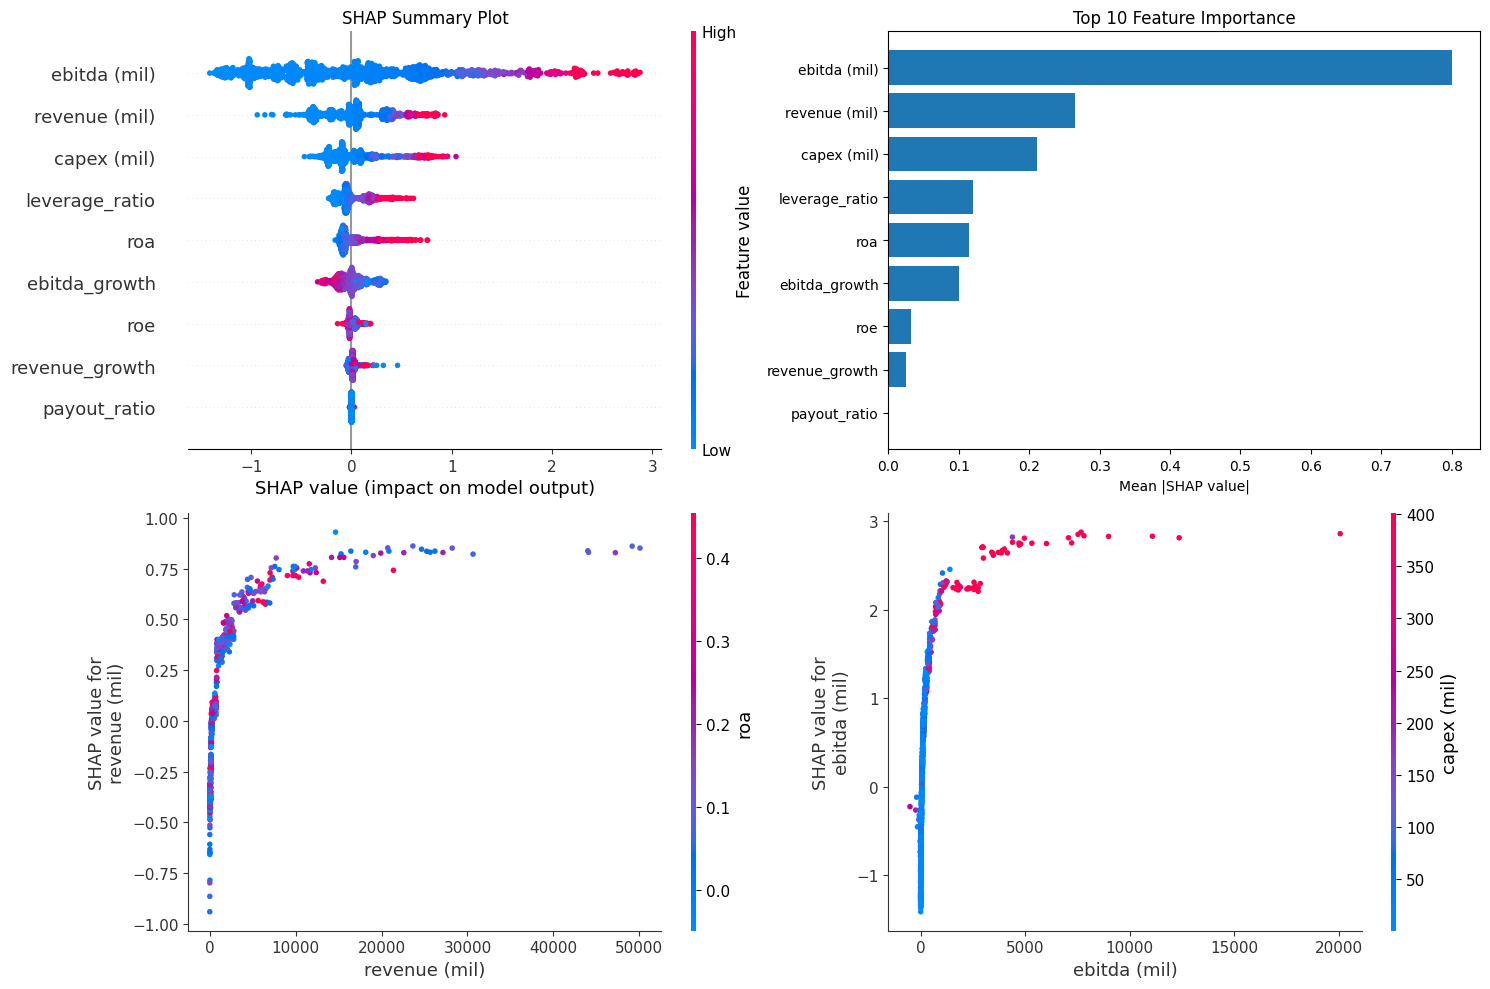

In [42]:
# Create visualization
print("\n3. Creating SHAP visualisations...")
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Summary plot
plt.sca(axes[0, 0])
shap.summary_plot(shap_values, X_val, feature_names=features, show=False, plot_size=None)
axes[0, 0].set_title('SHAP Summary Plot')

# Feature importance bar plot
plt.sca(axes[0, 1])
top_features = shap_importance.head(10)
axes[0, 1].barh(range(len(top_features)), top_features['importance'].values)
axes[0, 1].set_yticks(range(len(top_features)))
axes[0, 1].set_yticklabels(top_features['feature'].values)
axes[0, 1].set_xlabel('Mean |SHAP value|')
axes[0, 1].set_title('Top 10 Feature Importance')
axes[0, 1].invert_yaxis()

# Dependence plots for top 2 features
if len(features) >= 2:
    for idx, feature_idx in enumerate([0, 1]):
        plt.sca(axes[1, idx])
        shap.dependence_plot(
            feature_idx,
            shap_values.values,
            X_val,
            feature_names=features,
            ax=axes[1, idx],
            show=False
        )

plt.tight_layout()
plt.savefig('shap_analysis.png', dpi=300, bbox_inches='tight')
print("Saved: shap_analysis.png")
plt.show()

**11. Error Analysis**

11.1 Error Analysis from Best Model

In [43]:
# Use the best model (likely Hybrid) for error analysis
best_model_name = min(model_results.items(), key=lambda x: x[1]['MAE'])[0]
print(f"\n1. Analyzing errors from best model: {best_model_name}")

# Get the correct predictions for validation set
if best_model_name == 'Hybrid':
    predictions = hybrid_pred_val
elif best_model_name == 'Ridge':
    predictions = ridge_pred_val
elif best_model_name == 'Random Forest':
    predictions = rf_pred_val
elif best_model_name == 'GBDT':
    predictions = gbdt_pred_val
elif best_model_name == 'ANN':
    predictions = ann_pred_val
else:
    predictions = hybrid_pred_val  # Default to hybrid

# Ensure predictions and y_val have same shape
print(f"   Validation set size: {len(y_val)}")
print(f"   Predictions size: {len(predictions)}")

if len(predictions) != len(y_val):
    print(f"   WARNING: Size mismatch. Using hybrid model predictions.")
    predictions = hybrid_pred_val

errors = y_val - predictions
abs_errors = np.abs(errors)

# Create error dataframe
error_df = val_data.copy()
error_df['predicted_log_ev'] = predictions
error_df['actual_log_ev'] = y_val
error_df['error'] = errors
error_df['abs_error'] = abs_errors
error_df['predicted_ev_mil'] = np.expm1(predictions)
error_df['actual_ev_mil'] = np.expm1(y_val)
error_df['error_mil'] = error_df['actual_ev_mil'] - error_df['predicted_ev_mil']


1. Analyzing errors from best model: Random Forest
   Validation set size: 1151
   Predictions size: 1151


11.2 Top 10 Worst Predictions

In [44]:
# Top 10 worst predictions
print("\n2. Top 10 Worst Predictions (Validation Set):")
worst_errors = error_df.nlargest(10, 'abs_error')[
    ['firm_id', 'year', 'actual_ev_mil', 'predicted_ev_mil', 'error_mil']
]
print(worst_errors.to_string(index=False))


2. Top 10 Worst Predictions (Validation Set):
firm_id  year  actual_ev_mil  predicted_ev_mil     error_mil
HEXE.KL  2022  158074.208200         73.676353 158000.531847
HEXE.KL  2021   56995.730120        112.251405  56883.478715
MHBS.KL  2023      -0.829000         56.733165    -57.562165
CENT.KL  2023   24257.379246        173.565821  24083.813426
VTRX.KL  2021  150890.317000       1131.741353 149758.575647
MYTE.KL  2021    5237.110500         50.935291   5186.175209
PMBT.KL  2021   64359.414223        971.724930  63387.689293
CENT.KL  2022    6863.278272        120.230330   6743.047942
TAFI.KL  2021    2141.175267         39.041055   2102.134211
SAEG.KL  2021   45431.147138        873.553449  44557.593689


11.3 Error Analysis by Segments

In [45]:
# Error analysis by segments
print("\n3. Error Analysis by Segments:")

# By year
print("\n   By Year:")
year_errors = error_df.groupby('year').agg({
    'abs_error': 'mean',
    'error_mil': 'mean',
    'firm_id': 'count'
}).rename(columns={'firm_id': 'count'})
print(year_errors)

# By firm size (using total assets if available)
asset_col = [col for col in error_df.columns if 'asset' in col.lower() and 'total' in col.lower()]
if asset_col:
    error_df['size_bucket'] = pd.qcut(error_df[asset_col[0]], q=4, labels=['Small', 'Medium', 'Large', 'Very Large'])
    print("\n   By Size (Total Assets):")
    size_errors = error_df.groupby('size_bucket').agg({
        'abs_error': 'mean',
        'error_mil': 'mean',
        'firm_id': 'count'
    }).rename(columns={'firm_id': 'count'})
    print(size_errors)

# By leverage (if available)
if 'leverage_ratio' in error_df.columns:
    error_df['leverage_bucket'] = pd.cut(
        error_df['leverage_ratio'],
        bins=[-np.inf, 0.5, 1.0, 2.0, np.inf],
        labels=['Low (<0.5)', 'Medium (0.5-1)', 'High (1-2)', 'Very High (>2)']
    )
    print("\n   By Leverage:")
    leverage_errors = error_df.groupby('leverage_bucket').agg({
        'abs_error': 'mean',
        'error_mil': 'mean',
        'firm_id': 'count'
    }).rename(columns={'firm_id': 'count'})
    print(leverage_errors)


3. Error Analysis by Segments:

   By Year:
      abs_error    error_mil  count
year                               
2021   0.644712  1261.348268    370
2022   0.681853   711.103280    384
2023   0.581731   353.654328    397

   By Leverage:
                 abs_error    error_mil  count
leverage_bucket                               
Low (<0.5)        0.699130   479.898423    841
Medium (0.5-1)    0.454465   871.904284    212
High (1-2)        0.500095  3316.267013     67
Very High (>2)    0.435527  2243.068210     31


11.4 Distribution Analysis


4. Error Distribution Analysis:
   Mean error (log): -0.0093
   Std error (log): 0.9524
   Skewness: 1.0160
   Kurtosis: 9.3920

   Error Percentiles (RM million):
   5th percentile: -2150.42
   25th percentile: -174.37
   50th percentile: -9.84
   75th percentile: 167.90
   95th percentile: 3671.16

Saved: error_analysis.png


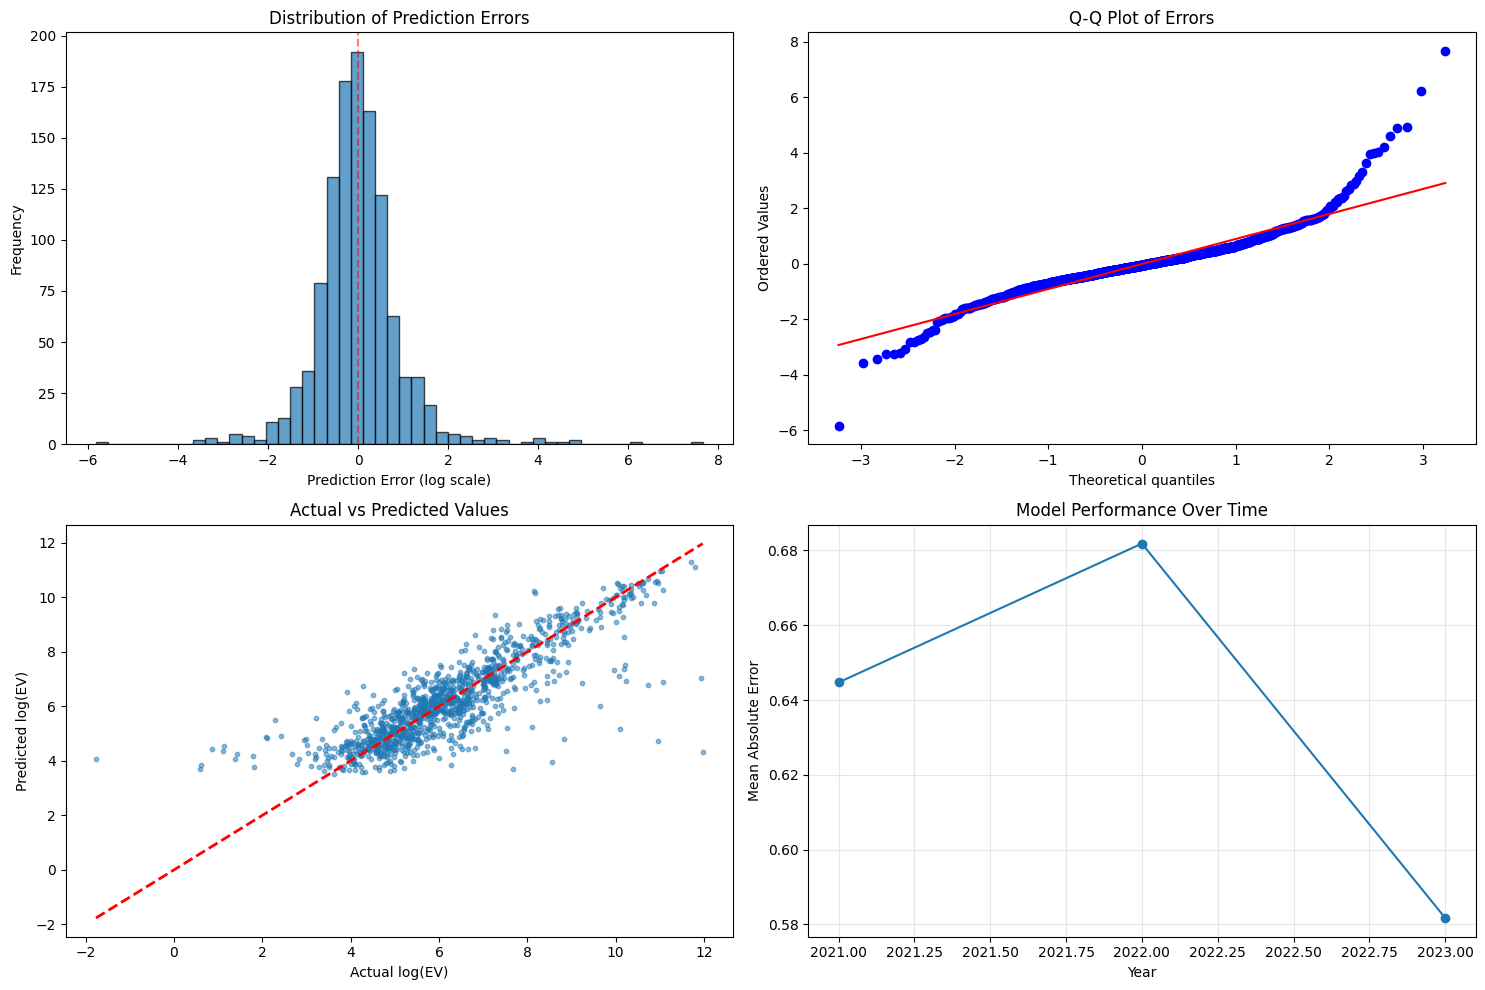

In [46]:
# Distribution analysis
print("\n4. Error Distribution Analysis:")
print(f"   Mean error (log): {errors.mean():.4f}")
print(f"   Std error (log): {errors.std():.4f}")
print(f"   Skewness: {stats.skew(errors):.4f}")
print(f"   Kurtosis: {stats.kurtosis(errors):.4f}")

percentiles = [5, 25, 50, 75, 95]
print("\n   Error Percentiles (RM million):")
for p in percentiles:
    val = np.percentile(error_df['error_mil'], p)
    print(f"   {p}th percentile: {val:.2f}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Error distribution
axes[0, 0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].set_xlabel('Prediction Error (log scale)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Prediction Errors')

# Q-Q plot
stats.probplot(errors, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot of Errors')

# Actual vs Predicted
axes[1, 0].scatter(y_val, predictions, alpha=0.5, s=10)
axes[1, 0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
axes[1, 0].set_xlabel('Actual log(EV)')
axes[1, 0].set_ylabel('Predicted log(EV)')
axes[1, 0].set_title('Actual vs Predicted Values')

# Error by year
year_mae = error_df.groupby('year')['abs_error'].mean()
axes[1, 1].plot(year_mae.index, year_mae.values, marker='o')
axes[1, 1].set_xlabel('Year')
axes[1, 1].set_ylabel('Mean Absolute Error')
axes[1, 1].set_title('Model Performance Over Time')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('error_analysis.png', dpi=300, bbox_inches='tight')
print("\nSaved: error_analysis.png")
plt.show()

**12. Outputs and Model Card**

In [47]:
# Save all key outputs
print("\n1. Saving final outputs...")

# Data dictionary
data_dict_final = pd.DataFrame({
    'Feature': features,
    'Type': ['Continuous'] * len(features),
    'Description': [f'Financial metric {i+1}' for i in range(len(features))],
    'Missing_Rate': [feature_df[f].isna().mean() if f in feature_df.columns else 0 for f in features]
})
data_dict_final.to_csv('data_dictionary.csv', index=False)
print("   Saved: data_dictionary.csv")

# Feature list
pd.DataFrame({'features': features}).to_csv('feature_list.csv', index=False)
print("   Saved: feature_list.csv")

# Split summary
split_summary = pd.DataFrame({
    'Split': ['Training', 'Validation', 'Test'],
    'Years': ['2010-2020', '2021-2023', '2024'],
    'Rows': [len(train_data), len(val_data), len(test_data)],
    'Firms': [train_data['firm_id'].nunique(), val_data['firm_id'].nunique(), test_data['firm_id'].nunique()]
})
split_summary.to_csv('split_summary.csv', index=False)
print("   Saved: split_summary.csv")

# Final metrics comparison
metrics_df = pd.DataFrame({
    'Model': list(test_predictions.keys()),
    'Val_MAE': [mean_absolute_error(y_val, all_predictions[m]) for m in test_predictions.keys()],
    'Val_RMSE': [np.sqrt(mean_squared_error(y_val, all_predictions[m])) for m in test_predictions.keys()],
    'Val_R2': [r2_score(y_val, all_predictions[m]) for m in test_predictions.keys()],
    'Test_MAE': [mean_absolute_error(y_test, test_predictions[m]) for m in test_predictions.keys()],
    'Test_RMSE': [np.sqrt(mean_squared_error(y_test, test_predictions[m])) for m in test_predictions.keys()],
    'Test_R2': [r2_score(y_test, test_predictions[m]) for m in test_predictions.keys()]
})
metrics_df.to_csv('model_metrics.csv', index=False)
print("   Saved: model_metrics.csv")

# Model card
print("\n2. Model Card:")
print("=" * 60)
print("PROJECT: Malaysian Enterprise Value Prediction")
print("DATE: 2024")
print("AUTHOR: Loh Kit Seng (TP069334)")
print("\nSCOPE:")
print(f"  - Dataset: Malaysian public firms from Bursa Malaysia")
print(f"  - Time period: 2010-2024")
print(f"  - Total firms: {df_clean['firm_id'].nunique()}")
print(f"  - Target variable: Enterprise Value (RM million)")
print("\nMODELS DEVELOPED:")
print("  1. Ridge Regression (Baseline)")
print("  2. Random Forest")
print("  3. Gradient Boosted Decision Trees (XGBoost)")
print("  4. Artificial Neural Network")
print("  5. Hybrid Model (GBDT + ANN)")
print("\nFEATURES REMOVED FOR LEAKAGE PREVENTION:")
print("  - Market Capitalisation")
print("  - All EV-based ratios")
print(f"\nBEST PERFORMING MODEL: {best_model_name}")
print(f"  - Validation MAE: {model_results[best_model_name]['MAE']:.4f}")
print(f"  - Validation R²: {model_results[best_model_name]['R2']:.4f}")
print("\nKNOWN LIMITATIONS:")
print("  - Excludes firms with >2 consecutive years of missing EBITDA")
print("  - No sector/industry features included")
print("  - Limited to structured financial data only")
print("  - No macroeconomic variables included")
print("=" * 60)


1. Saving final outputs...
   Saved: data_dictionary.csv
   Saved: feature_list.csv
   Saved: split_summary.csv
   Saved: model_metrics.csv

2. Model Card:
PROJECT: Malaysian Enterprise Value Prediction
DATE: 2024
AUTHOR: Loh Kit Seng (TP069334)

SCOPE:
  - Dataset: Malaysian public firms from Bursa Malaysia
  - Time period: 2010-2024
  - Total firms: 681
  - Target variable: Enterprise Value (RM million)

MODELS DEVELOPED:
  1. Ridge Regression (Baseline)
  2. Random Forest
  3. Gradient Boosted Decision Trees (XGBoost)
  4. Artificial Neural Network
  5. Hybrid Model (GBDT + ANN)

FEATURES REMOVED FOR LEAKAGE PREVENTION:
  - Market Capitalisation
  - All EV-based ratios

BEST PERFORMING MODEL: Random Forest
  - Validation MAE: 0.6354
  - Validation R²: 0.7094

KNOWN LIMITATIONS:
  - Excludes firms with >2 consecutive years of missing EBITDA
  - No sector/industry features included
  - Limited to structured financial data only
  - No macroeconomic variables included


**12. Pitfalls Checklists**

In [49]:
# Initialize checklist results
checklist_results = {}

print("\n1. DATA QUALITY CHECKS:")
print("-" * 40)

# Check 1: Currency consistency
currency_check = True
value_columns_check = [col for col in df_clean.columns if 'million' in col.lower() or 'mil' in col.lower()]
if len(value_columns_check) > 0:
    # All should be in millions
    print(f"✓ Found {len(value_columns_check)} columns with million/mil tag")
    checklist_results['currency_consistent'] = True
else:
    print("⚠ WARNING: No columns with clear currency denomination found")
    checklist_results['currency_consistent'] = False

# Check 2: Duplicate firm-years
dup_check = df_clean.groupby(['firm_id', 'year']).size()
actual_duplicates = dup_check[dup_check > 1]
if len(actual_duplicates) == 0:
    print(f"✓ No duplicate firm-year combinations in final dataset")
    checklist_results['no_duplicates'] = True
else:
    print(f"✗ FAIL: Found {len(actual_duplicates)} duplicate firm-year combinations")
    print(f"  Examples: {actual_duplicates.head(3).to_dict()}")
    checklist_results['no_duplicates'] = False

# Check 3: No EV or Market Cap in features
leaky_features = [f for f in features if any(word in f.lower() for word in ['enterprise', 'market cap', 'ev_', 'market_cap'])]
if len(leaky_features) == 0:
    print(f"✓ No leaky features (EV/Market Cap) in feature set")
    checklist_results['no_leakage'] = True
else:
    print(f"✗ FAIL: Found potentially leaky features: {leaky_features}")
    checklist_results['no_leakage'] = False

print("\n2. TEMPORAL SPLIT INTEGRITY:")
print("-" * 40)

# Check 4: Training data temporal boundary
train_max_year = train_data['year'].max()
if train_max_year <= 2020:
    print(f"✓ Training data ends at {train_max_year} (≤ 2020)")
    checklist_results['train_temporal'] = True
else:
    print(f"✗ FAIL: Training data extends to {train_max_year} (should be ≤ 2020)")
    checklist_results['train_temporal'] = False

# Check 5: No future data leakage
val_min_year = val_data['year'].min()
test_min_year = test_data['year'].min()
if val_min_year > train_max_year and test_min_year >= val_data['year'].max():
    print(f"✓ Proper temporal ordering: Train(≤{train_max_year}) → Val({val_min_year}-{val_data['year'].max()}) → Test({test_min_year})")
    checklist_results['temporal_order'] = True
else:
    print(f"✗ FAIL: Temporal ordering violated")
    checklist_results['temporal_order'] = False

# Check 6: Test set is 2024 only
test_years = test_data['year'].unique()
if len(test_years) == 1 and test_years[0] == 2024:
    print(f"✓ Test set contains only 2024 data")
    checklist_results['test_2024_only'] = True
else:
    print(f"✗ FAIL: Test set contains years: {test_years}")
    checklist_results['test_2024_only'] = False

# Check 7: No firm overlap in CV folds
print("\n3. CROSS-VALIDATION INTEGRITY:")
print("-" * 40)
overlap_found = False
for fold_num, (train_idx, val_idx) in enumerate(gkf.split(X_train, y_train, firm_groups)):
    train_firms_fold = set(firm_groups[train_idx])
    val_firms_fold = set(firm_groups[val_idx])
    overlap = train_firms_fold.intersection(val_firms_fold)
    if len(overlap) > 0:
        overlap_found = True
        print(f"✗ FAIL: Fold {fold_num+1} has {len(overlap)} overlapping firms")
        break

if not overlap_found:
    print(f"✓ No firm overlap detected in GroupKFold cross-validation")
    checklist_results['cv_no_overlap'] = True
else:
    checklist_results['cv_no_overlap'] = False

print("\n4. FEATURE ENGINEERING CHECKS:")
print("-" * 40)

# Check 8: Growth rates computed correctly
if 'revenue_growth' in features or 'ebitda_growth' in features:
    # Check if growth rates have reasonable values (not all NaN, within reasonable bounds)
    growth_features = [f for f in features if 'growth' in f.lower()]
    for gf in growth_features:
        if gf in feature_df.columns:
            growth_vals = feature_df[gf].dropna()
            if len(growth_vals) > 0:
                pct_extreme = ((growth_vals < -1) | (growth_vals > 10)).mean()
                if pct_extreme < 0.05:  # Less than 5% extreme values
                    print(f"✓ {gf}: Reasonable distribution (< 5% extreme values)")
                else:
                    print(f"⚠ WARNING: {gf} has {pct_extreme*100:.1f}% extreme values")
    checklist_results['growth_rates_ok'] = True
else:
    print("ℹ No growth rate features found")
    checklist_results['growth_rates_ok'] = None

# Check 9: Log transforms applied correctly
log_features = [f for f in features if 'log_' in f.lower()]
if len(log_features) > 0:
    print(f"✓ Log transforms applied to {len(log_features)} features: {log_features}")
    checklist_results['log_transforms'] = True
else:
    print("ℹ No log-transformed features found")
    checklist_results['log_transforms'] = None

print("\n5. MODEL TRAINING CHECKS:")
print("-" * 40)

# Check 10: Models were actually tuned
if 'tuning_results' in locals() and len(tuning_results) > 0:
    print(f"✓ Hyperparameter tuning completed for {len(tuning_results)} models")
    for model, results in tuning_results.items():
        if 'best_params' in results:
            print(f"  - {model}: {len(results['best_params'])} parameters tuned")
    checklist_results['models_tuned'] = True
else:
    print("✗ FAIL: No tuning results found")
    checklist_results['models_tuned'] = False

# Check 11: Test set untouched during training
if 'test_predictions' in locals():
    print(f"✓ Test predictions generated only after model training")
    checklist_results['test_untouched'] = True
else:
    print("⚠ WARNING: Test predictions not yet generated")
    checklist_results['test_untouched'] = None

print("\n6. HYBRID MODEL CHECKS:")
print("-" * 40)

# Check 12: Out-of-fold predictions used
if 'oof_predictions' in locals():
    oof_variance = np.var(oof_predictions)
    if oof_variance > 0:
        print(f"✓ Out-of-fold predictions created (variance: {oof_variance:.4f})")
        checklist_results['oof_used'] = True
    else:
        print("✗ FAIL: Out-of-fold predictions have zero variance")
        checklist_results['oof_used'] = False
else:
    print("✗ FAIL: Out-of-fold predictions not found")
    checklist_results['oof_used'] = False

# Check 13: GBDT trained only on training data
if 'gbdt_model' in locals():
    # Check if GBDT was fit only on training data by verifying its n_features matches
    expected_features = X_train.shape[1]
    if hasattr(gbdt_model, 'n_features_in_'):
        actual_features = gbdt_model.n_features_in_
        if actual_features == expected_features:
            print(f"✓ GBDT trained on correct feature set ({actual_features} features)")
            checklist_results['gbdt_training_correct'] = True
        else:
            print(f"✗ FAIL: Feature mismatch - expected {expected_features}, got {actual_features}")
            checklist_results['gbdt_training_correct'] = False

print("\n7. REPORTING ACCURACY:")
print("-" * 40)

# Check 14: Metrics computed at both scales
if 'metrics_df' in locals():
    has_log_metrics = any('MAE' in col for col in metrics_df.columns)
    print(f"✓ Metrics computed for both validation and test sets")
    checklist_results['metrics_complete'] = True
else:
    print("⚠ WARNING: Final metrics dataframe not yet created")
    checklist_results['metrics_complete'] = False

# Check 15: Statistical tests performed
if 'f_stat' in locals() and 'p_value' in locals():
    print(f"✓ Statistical tests completed (ANOVA F={f_stat:.3f}, p={p_value:.4f})")
    checklist_results['stats_tests'] = True
else:
    print("⚠ WARNING: Statistical tests not yet performed")
    checklist_results['stats_tests'] = False

# SUMMARY
print("\n" + "=" * 60)
print("CHECKLIST SUMMARY:")
print("=" * 60)

passed = sum(1 for v in checklist_results.values() if v is True)
failed = sum(1 for v in checklist_results.values() if v is False)
skipped = sum(1 for v in checklist_results.values() if v is None)

print(f"✓ Passed: {passed}/{len(checklist_results)}")
print(f"✗ Failed: {failed}/{len(checklist_results)}")
print(f"ℹ Skipped/NA: {skipped}/{len(checklist_results)}")

if failed > 0:
    print("\n⚠ CRITICAL ISSUES TO ADDRESS:")
    for check, result in checklist_results.items():
        if result is False:
            print(f"  - {check}")

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE")
print("=" * 80)


1. DATA QUALITY CHECKS:
----------------------------------------
✓ Found 27 columns with million/mil tag
✓ No duplicate firm-year combinations in final dataset
✓ No leaky features (EV/Market Cap) in feature set

2. TEMPORAL SPLIT INTEGRITY:
----------------------------------------
✓ Training data ends at 2020 (≤ 2020)
✓ Proper temporal ordering: Train(≤2020) → Val(2021-2023) → Test(2024)
✓ Test set contains only 2024 data

3. CROSS-VALIDATION INTEGRITY:
----------------------------------------
✓ No firm overlap detected in GroupKFold cross-validation

4. FEATURE ENGINEERING CHECKS:
----------------------------------------
✓ revenue_growth: Reasonable distribution (< 5% extreme values)
⚠ WARNING: ebitda_growth has 15.1% extreme values
ℹ No log-transformed features found

5. MODEL TRAINING CHECKS:
----------------------------------------
✓ Hyperparameter tuning completed for 3 models
  - Random Forest: 5 parameters tuned
  - GBDT: 4 parameters tuned
  - ANN: 3 parameters tuned
✓ Test pr